# Initialise and clean the dataset before training 

In [ ]:
# example of making predictions for a regression problem
import pandas as pd
import numpy as np
from numpy import array

import keras
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, GRU

from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from matplotlib import pyplot as plt
from datetime import datetime as datetime
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# read the file
climate_data = pd.read_csv("GlobalLandTemperaturesByMajorCity.csv")
climate_data = climate_data.dropna()
climate_data = climate_data.drop(['AverageTemperatureUncertainty'], axis = 1)
CD = climate_data.copy()
climate_data.head()

,dt,AverageTemperature,City,Country,Latitude,Longitude
0,1849-01-01,26.704,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [ ]:
# get user input to determine which country or city will be used for prediction 
user_country=''
user_city=''

i=0
while i<1:
  prompt = input('Would you like to analyse a Country or City: ')
  if prompt=='Country' or prompt=='country':
      user_country = input("Enter the country you want to predict: ")
      CD2 = CD[CD["Country"] == (user_country)].copy()
      CD2 = CD2.drop(['City','Country'], axis = 1)
      i=1
  elif prompt=='City' or prompt=='city':
      user_city = input("Enter the city you want to predict: ")
      CD2 = CD[CD["City"] == (user_city)].copy()
      CD2 = CD2.drop(['City','Country'], axis = 1)
      i=1
  else:
      print ("You didn't enter a valid input, try again.")
      i=0

date_input = input("Enter the year you would like to predict average annual temperature for: ")
start_input = input("Enter the year you would like the algorithm to begin training from: ")
end_input = input("Enter the year you would like the algorithm to stop training at: ")
user_date = int(date_input)

Would you like to analyse a Country or City: City
Enter the city you want to predict: Toronto
Enter the year you would like to predict average annual temperature for: 2050
Enter the year you would like the algorithm to begin training from: 1900
Enter the year you would like the algorithm to stop training at: 2010


In [ ]:
#convert each individual reading per year to an annual mean
CD2["dt"] = pd.to_datetime(CD2["dt"])
data_country_mean = CD2.groupby([pd.Grouper(key='dt', freq='Y')])['AverageTemperature'].mean().reset_index(name='AverageTemperatureYear')
data_country_mean['dt'] = data_country_mean['dt'].dt.year
data_country_mean_year = data_country_mean.dropna()
data_country_mean_year.head()

,dt,AverageTemperatureYear
0,1743,-0.106000
1,1744,8.378625
2,1745,-3.962500
7,1750,6.294545
8,1751,6.838625


In [ ]:
mask = (data_country_mean_year['dt'] > int(start_input)) & (data_country_mean_year['dt'] <= int(end_input))
column = ('dt','AverageTemperatureYear')
data_country_mean_range = data_country_mean_year.loc[mask,column]
data_country_mean_range

,dt,AverageTemperatureYear
158,1901,5.701833
159,1902,5.797833
160,1903,5.792833
161,1904,3.854500
162,1905,5.212250
...,...,...
263,2006,7.846833
264,2007,7.071333
265,2008,6.576750
266,2009,6.282583


In [ ]:
#set the the train test split for the training set and target set
X_training = data_country_mean_range['dt']
X_target = data_country_mean_range['AverageTemperatureYear']
(X_train, X_test, Y_train, Y_test) = train_test_split(X_training, X_target, test_size=0.2, random_state=1)

<Figure size 432x288 with 0 Axes>

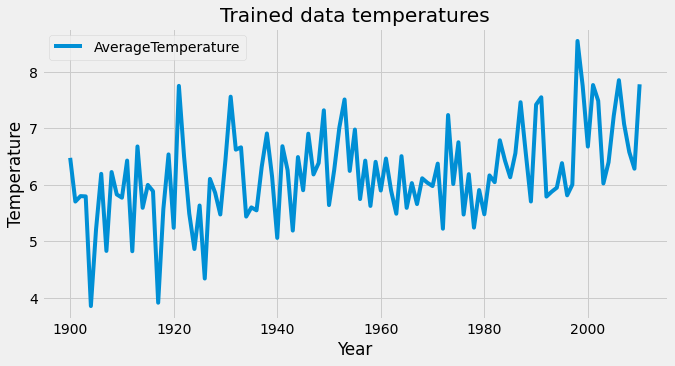

In [ ]:
# plot the training data for referance
data_country = CD2.copy()
data_country["dt"] = pd.to_datetime(data_country["dt"])
annual_mean = data_country.groupby(data_country["dt"].dt.year).mean()

plt.figure()
plt.style.use("fivethirtyeight")
annual_mean.loc[int(start_input):int(end_input)][["AverageTemperature"]].plot(figsize = (10,5), grid=True, legend=True)
plt.title("Trained data temperatures")
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

# Neural network using Dense RNN

In [ ]:
# build a regression neural network
model1 = Sequential()
model1.add(Dense(512, input_shape=(1,), activation='relu'))
#model.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='linear'))
model1.compile(loss = 'mean_squared_error',metrics = ['mae','mape'], optimizer = 'adam')
early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

In [ ]:
# train the model
history1 = model1.fit(X_train, Y_train, 
                    epochs = 1000, 
                    verbose=0,
                    batch_size=128, 
                    validation_split=0.2,
                    callbacks = [early_stopping])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# evaluate the model
score1 = model1.evaluate(X_test, Y_test)
print("Test loss: {:.2f}".format(score1[0]))
print("Test mae: {:.2f}".format(score1[1]))
print("Test mape: {:.2f}".format(score1[2]))

1/1 [==============================] - 0s 20ms/step - loss: 0.5537 - mae: 0.5431 - mape: 8.1353
Test loss: 0.55
Test mae: 0.54
Test mape: 8.14


In [ ]:
# new instance where we do not know the answer
Xnew1 = array([[user_date]])
# make a prediction
ynew1 = model1.predict(Xnew1)
# show the inputs and predicted outputs
print("The predicted temperature for the year %s is %s" % ((date_input), ynew1[0]))

1/1 [==============================] - 0s 77ms/step
The predicted temperature for the year 2050 is [6.517042]


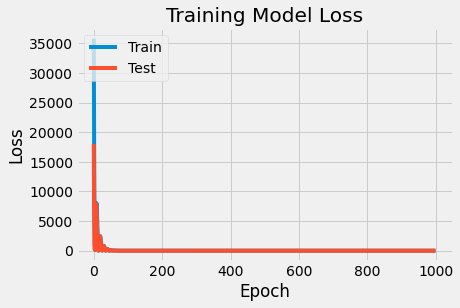

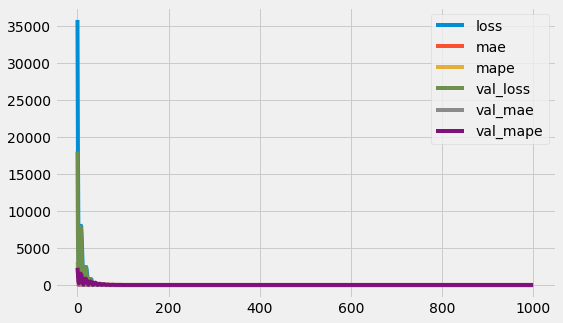

In [ ]:
# visualise the training and testing loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Training Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

pd.DataFrame(history1.history).plot(figsize=(8,5))
plt.show()

# Neural Network using LSTM RNN

In [ ]:
# build a regression neural network
model2 = Sequential()
model2.add(LSTM(512, input_shape=(1,1), activation='relu'))
model2.add(Dense(1, activation='linear'))
model2.compile(loss = 'mean_squared_error',metrics = ['mae','mape'], optimizer = 'adam')
early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

In [ ]:
# train the model
history2 = model2.fit(X_train, Y_train, 
                    epochs = 1000, 
                    verbose=0,
                    batch_size=128, 
                    validation_split=0.2,
                    callbacks = [early_stopping])
model2.summary()

Epoch 387: early stopping
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1052672   
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# evaluate the model
score2 = model2.evaluate(X_test, Y_test)
print("Test loss: {:.2f}".format(score2[0]))
print("Test mae: {:.2f}".format(score2[1]))
print("Test mape: {:.2f}".format(score2[2]))

1/1 [==============================] - 0s 26ms/step - loss: 0.5541 - mae: 0.5435 - mape: 8.1436
Test loss: 0.55
Test mae: 0.54
Test mape: 8.14


In [ ]:
# new instance where we do not know the answer
Xnew2 = array([[user_date]])
# make a prediction
ynew2 = model2.predict(Xnew2)
# show the inputs and predicted outputs
print("The predicted temperature for the year %s is %s" % ((date_input), ynew2[0]))

1/1 [==============================] - 0s 177ms/step
The predicted temperature for the year 2050 is [6.51593]


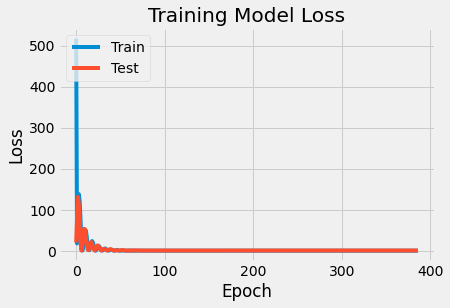

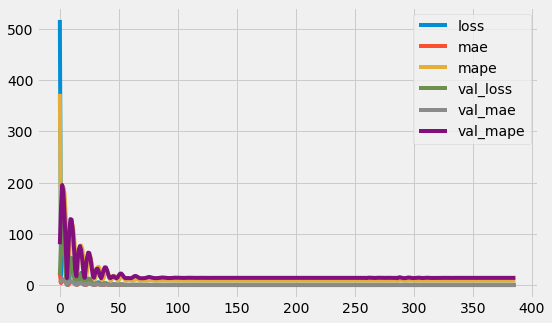

In [ ]:
# visualise the training and testing loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.show()

# Neural Network using GRU RNN

In [ ]:
# build a regression neural network
model3 = Sequential()
model3.add(GRU(512, input_shape=(1,1), activation='relu'))
model3.add(Dense(1, activation='linear'))
model3.compile(loss = 'mean_squared_error',metrics = ['mae','mape'], optimizer = 'adam')
early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

In [ ]:
# train the model
history3 = model3.fit(X_train, Y_train, 
                    epochs = 1000, 
                    verbose=0,
                    batch_size=128, 
                    validation_split=0.2,
                    callbacks = [early_stopping])
model3.summary()

Epoch 307: early stopping
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 512)               791040    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# evaluate the model
score3 = model3.evaluate(X_test, Y_test)
print("Test loss: {:.2f}".format(score3[0]))
print("Test mae: {:.2f}".format(score3[1]))
print("Test mape: {:.2f}".format(score3[2]))

1/1 [==============================] - 0s 23ms/step - loss: 0.5545 - mae: 0.5435 - mape: 8.1405
Test loss: 0.55
Test mae: 0.54
Test mape: 8.14


In [ ]:
# new instance where we do not know the answer
Xnew3 = array([[user_date]])
# make a prediction
ynew3 = model1.predict(Xnew3)
# show the inputs and predicted outputs
print("The predicted temperature for the year %s is %s" % ((date_input), ynew3[0]))

1/1 [==============================] - 0s 24ms/step
The predicted temperature for the year 2050 is [6.517042]


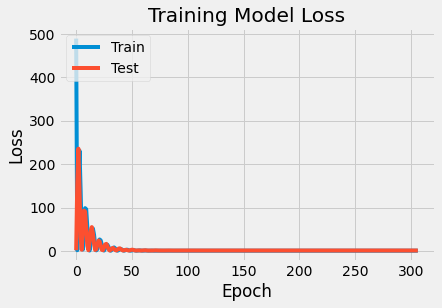

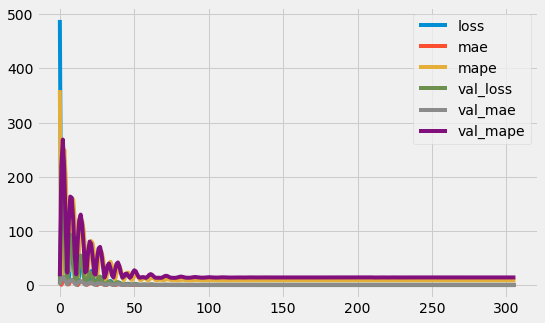

In [ ]:
# visualise the training and testing loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Training Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

pd.DataFrame(history3.history).plot(figsize=(8,5))
plt.show()